In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import display
import imageio

In [2]:
images = np.load('anime.npy')

In [3]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [4]:
latent_dim = 3072 

encoder_inputs = keras.Input(shape=(64, 64, 3))
x = layers.Conv2D(32, 8, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 6, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 4, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 4, activation="relu", strides=2, padding="same")(x)

x = layers.Flatten()(x)
x = layers.Dense(latent_dim, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

In [5]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(latent_dim, activation="relu")(latent_inputs)
x = layers.Reshape((32, 32, 3))(x)
x = layers.Conv2DTranspose(128, 4, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 8, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(32, 6, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [6]:
encoder.load_weights('vaeenc.h5')
decoder.load_weights('vaedec.h5')

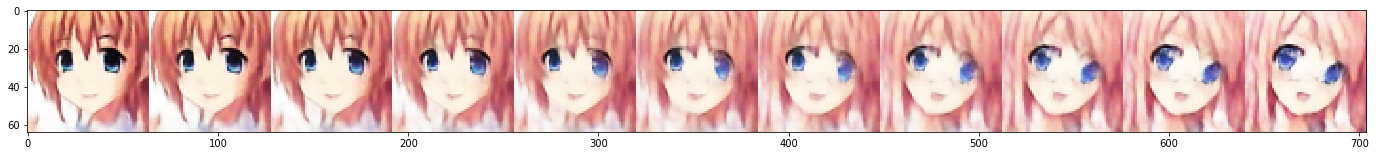

In [7]:
plt.figure(figsize=(24,16))
display.linear_interpolation(images[8], images[20099], encoder, decoder)

In [8]:
latent_frames = display.linear_interpolation_frames(images[8], images[20099], encoder, decoder)

In [9]:
latent_frames = np.array(latent_frames)

In [10]:
latent_frames.shape

(11, 64, 64, 3)

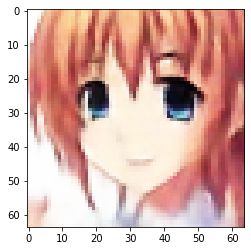

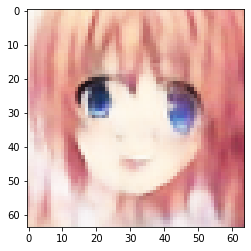

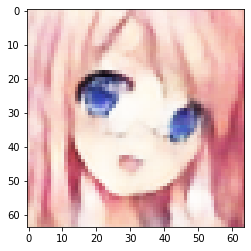

In [11]:
plt.imshow(latent_frames[0])
plt.show()
plt.imshow(latent_frames[5])
plt.show()
plt.imshow(latent_frames[10])
plt.show()

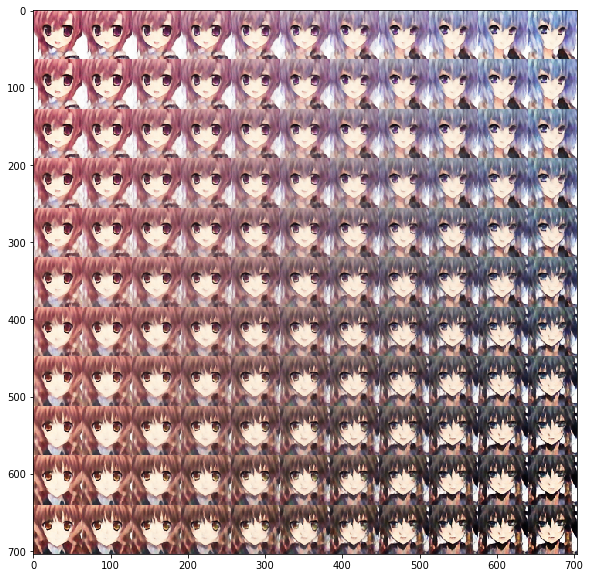

In [12]:
plt.figure(figsize=(10,10))
display.grid(images[0], images[1], images[2], images[3], encoder, decoder, save=(True, 'transitiongrid.png'))

In [13]:
anim_frames = []

num_faces = 10

for i in range(num_faces):
    frames = display.linear_interpolation_frames(images[i], images[i+1], encoder, decoder, steps=10)
    anim_frames.append(frames)

In [14]:
anim_frames = np.array(anim_frames).reshape(11*num_faces, 64, 64, 3)

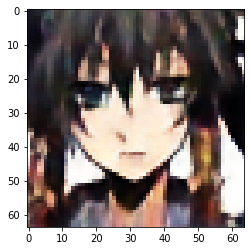

In [15]:
plt.imshow(anim_frames[32])

In [16]:
display.save_gif(anim_frames, 'faces.gif')